## Import libraries

In [1]:
import os
import sys
from pathlib import Path
sys.path.append(os.getcwd())
sys.path.append(str(Path(os.getcwd()).parent))
sys.path.append(os.path.join(os.getcwd(), 'utils'))
from configuration import *
import torch
import pprint
import pNN_Power_Aware as pNN
from utils import *
import matplotlib.pyplot as plt
import pandas as pd


args = parser.parse_args([])
args = FormulateArgs(args)
args.act = 'relu'


In [2]:
num_seeds = 10
num_dataset = 13

## Check the existence of models

In [ ]:
from tqdm.notebook import tqdm

# results = torch.zeros([num_dataset, num_seeds, 51, 8])
gammas = torch.linspace(0, 1, 51)

# evaluator = Evaluator(args).to(args.DEVICE)

for ds in tqdm(range(num_dataset), desc="Datasets"):
    args.DATASET = ds
    # valid_loader, datainfo = GetDataLoader(args, 'valid', path='../dataset/')
    test_loader, datainfo = GetDataLoader(args, 'test', path='../dataset/')
    print(datainfo)

    for seed in tqdm(range(num_seeds), desc="Seeds", leave=False):

        args.SEED = seed
            
        for g, gamma in enumerate(tqdm(gammas, desc="Gammas", leave=False)):
            # rounded_num = np.round(gamma, 3)
                
            # # Convert to string and remove trailing zeros
            # formatted_num = ('{:.3f}'.format(rounded_num)).rstrip('0')
            # if formatted_num[-1] == '.':
            #     formatted_num += '0'
            
            # # Special case for 0 and 1 to ensure they have one decimal place
            # if rounded_num == 0 or rounded_num == 1:
            #     formatted_num = '{:.1f}'.format(rounded_num)
            # args.powerbalance = formatted_num
            args.powerbalance = int(np.round(gamma, 3)*1e2)
            if args.powerbalance == 58:
                args.powerbalance = 57
            
            # for x, y in valid_loader:
            #     X_valid, y_valid = x.to(args.DEVICE), y.to(args.DEVICE)
            # for x, y in test_loader:
            #     X_test, y_test = x.to(args.DEVICE), y.to(args.DEVICE)

            setup = f"data_{datainfo['dataname']}_seed_{args.SEED}_Penalty_{args.powerestimator}_Factor_{args.powerbalance}"

            model_PT_name = f'./models/pNN_{setup}.model'
            model_FT_name = f'./models/pNN_{setup}_FT.model'
            
            try:
                model_PT = torch.load(model_PT_name)
            except Exception as e:
                print(f"Error loading model_PT: {model_PT_name}")
                print(e)
                continue
            
            try:
                model_FT = torch.load(model_FT_name)
            except Exception as e:
                print(f"Error loading model_FT: {model_FT_name}")
                print(e)
                continue
            
            # acc_valid_pt, power_valid_pt = evaluator(model_PT, X_valid, y_valid)
            # acc_test_pt, power_test_pt = evaluator(model_PT, X_test, y_test)

            # acc_valid_ft, power_valid_ft = evaluator(model_FT, X_valid, y_valid)
            # acc_test_ft, power_test_ft = evaluator(model_FT, X_test, y_test)
            
            # results[ds, seed, g, 0] = acc_valid_pt
            # results[ds, seed, g, 1] = power_valid_pt.cpu().item() * 1000000
            # results[ds, seed, g, 2] = acc_test_pt
            # results[ds, seed, g, 3] = power_test_pt.cpu().item() * 1000000

            # results[ds, seed, g, 4] = acc_valid_ft
            # results[ds, seed, g, 5] = power_valid_ft.cpu().item() * 1000000
            # results[ds, seed, g, 6] = acc_test_ft
            # results[ds, seed, g, 7] = power_test_ft.cpu().item() * 1000000


In [ ]:
# torch.save(results, './result.matrix')
# torch.save(results, '../RESULT/result.matrix')

In [3]:
results = torch.load('./result.matrix')
alpha = torch.linspace(0,1,51)
results.shape

torch.Size([13, 10, 51, 8])

check the accuracy for each weight

In [4]:
result_table = results.clone()
mean_acc_0 = result_table[:,:,0,6].mean(1)
mean_power_0 = result_table[:,:,0,7].mean(1)
mean_acc_25 = result_table[:,:,12,6].mean(1)
mean_power_25 = result_table[:,:,12,7].mean(1)
mean_acc_50 = result_table[:,:,25,6].mean(1)
mean_power_50 = result_table[:,:,25,7].mean(1)
mean_acc_75 = result_table[:,:,37,6].mean(1)
mean_power_75 = result_table[:,:,37,7].mean(1)
mean_acc_100 = result_table[:,:,50,6].mean(1)
mean_power_100 = result_table[:,:,50,7].mean(1)

std_acc_0 = result_table[:,:,0,6].std(1)
std_power_0 = result_table[:,:,0,7].std(1)
std_acc_25 = result_table[:,:,12,6].std(1)
std_power_25 = result_table[:,:,12,7].std(1)
std_acc_50 = result_table[:,:,25,6].std(1)
std_power_50 = result_table[:,:,25,7].std(1)
std_acc_75 = result_table[:,:,37,6].std(1)
std_power_75 = result_table[:,:,37,7].std(1)
std_acc_100 = result_table[:,:,50,6].std(1)
std_power_100 = result_table[:,:,50,7].std(1)

In [5]:
mean_acc_0.shape

torch.Size([13])

In [6]:
table = torch.stack([mean_acc_0*100, std_acc_0*100, mean_power_0*1e-3, std_power_0*1e-3,
                     mean_acc_25*100, std_acc_25*100, mean_power_25*1e-3, std_power_25*1e-3,
                     mean_acc_50*100, std_acc_50*100, mean_power_50*1e-3, std_power_50*1e-3,
                     mean_acc_75*100, std_acc_75*100, mean_power_75*1e-3, std_power_75*1e-3,
                     mean_acc_100*100, std_acc_100*100, mean_power_100*1e-3, std_power_100*1e-3]).T
table = table.numpy()
np.savetxt('resut_table.txt', table, delimiter='\t', fmt='%0.5f')
# power in mW - the power were in watts and we convert to mW
columns = ['mean_acc_0', 'std_acc_0', 'mean_power_0 (mili)', 'std_power_0',
           'mean_acc_25', 'std_acc_25', 'mean_power_25 (mili)', 'std_power_25',
           'mean_acc_50', 'std_acc_50', 'mean_power_50 (mili)', 'std_power_50',
           'mean_acc_75', 'std_acc_75', 'mean_power_75 (mili)', 'std_power_75',
           'mean_acc_100', 'std_acc_100', 'mean_power_100 (mili)', 'std_power_100']

# Convert to DataFrame for better presentation
df = pd.DataFrame(
    table,
    columns=columns,
)

normal_datasets = ['Dataset_acuteinflammation.p',
                       'Dataset_balancescale.p',
                       'Dataset_breastcancerwisc.p',
                       'Dataset_cardiotocography3clases.p',
                       'Dataset_energyy1.p',
                       'Dataset_energyy2.p',
                       'Dataset_iris.p',
                       'Dataset_mammographic.p',
                       'Dataset_pendigits.p',
                       'Dataset_seeds.p',
                       'Dataset_tictactoe.p',
                       'Dataset_vertebralcolumn2clases.p',
                       'Dataset_vertebralcolumn3clases.p']

# Insert the new column at the first position (index 0)
df.insert(0, 'Dataset', normal_datasets)

# Save the DataFrame to a excel file
df.to_excel('Baseline_Sigmoid_result_table.xlsx', index=False)

# Display the DataFrame in a nice format
print(df.to_markdown())

|    | Dataset                           |   mean_acc_0 |   std_acc_0 |   mean_power_0 (mili) |   std_power_0 |   mean_acc_25 |   std_acc_25 |   mean_power_25 (mili) |   std_power_25 |   mean_acc_50 |   std_acc_50 |   mean_power_50 (mili) |   std_power_50 |   mean_acc_75 |   std_acc_75 |   mean_power_75 (mili) |   std_power_75 |   mean_acc_100 |   std_acc_100 |   mean_power_100 (mili) |   std_power_100 |
|---:|:----------------------------------|-------------:|------------:|----------------------:|--------------:|--------------:|-------------:|-----------------------:|---------------:|--------------:|-------------:|-----------------------:|---------------:|--------------:|-------------:|-----------------------:|---------------:|---------------:|--------------:|------------------------:|----------------:|
|  0 | Dataset_acuteinflammation.p       |     100      |     0       |             14.9547   |   42.7344     |       74.8    |     30.6406  |               0.446824 |      0.149136  |

## Figure

In [11]:
# Average over seeds
result_seed_mean = results.mean(1)
result_seed_mean = result_seed_mean[:, :, 6:]
print(result_seed_mean.shape)

# Normalize the results (divide by the largest value) 
for ds in range(13):
    result_seed_mean[ds,:,0] = result_seed_mean[ds,:,0] / result_seed_mean[ds,0,0]
    result_seed_mean[ds,:,1] = result_seed_mean[ds,:,1] / result_seed_mean[ds,0,1]

torch.Size([13, 51, 2])


smooth version of degradagtion of accuracy

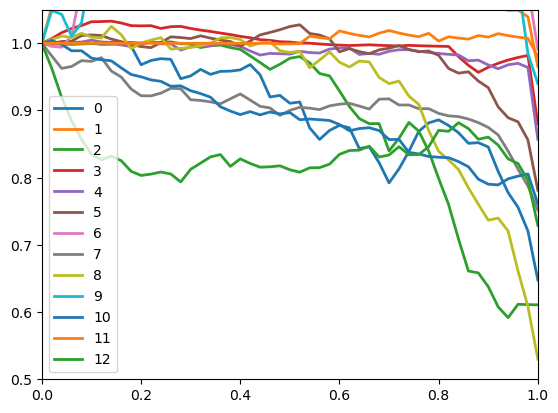

In [20]:
def exponential_moving_average(y, alpha=0.3):
    ema = np.zeros_like(y)
    ema[0] = y[0]  # Initialize with the first value
    for i in range(1, len(y)):
        ema[i] = alpha * y[i] + (1 - alpha) * ema[i - 1]
    return ema

# Plot with EMA smoothing
for ds in range(13):
    smoothed_data = exponential_moving_average(result_seed_mean[ds, :, 0], alpha=0.2)  # Adjust alpha for smoothness
    plt.plot(alpha, smoothed_data, lw=2, label=f'{ds}')

plt.xlim([0, 1])
plt.ylim([0.5, 1.05])
plt.legend(loc='best')
plt.show()


actual version of accuracy degradation

(0.2, 1.5)

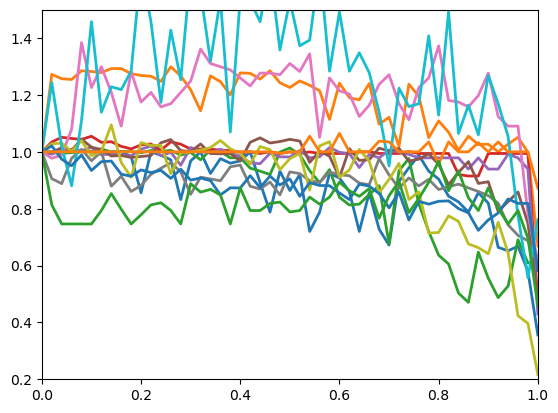

In [21]:
# acc for each alpha
for ds in range(13):
    plt.plot(alpha, result_seed_mean[ds,:,0], lw=2, label=f'{ds}')
plt.xlim([0,1])
plt.ylim([0.2,1.5])
# plt.axis('off')
# plt.savefig("../figures/single_acc.pdf", format='pdf', bbox_inches='tight', transparent=True)

smooth version of power imporvement

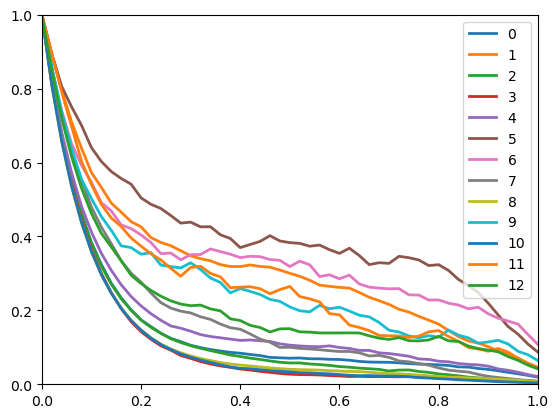

In [22]:
def exponential_moving_average(y, alpha=0.3):
    ema = np.zeros_like(y)
    ema[0] = y[0]  # Initialize with the first value
    for i in range(1, len(y)):
        ema[i] = alpha * y[i] + (1 - alpha) * ema[i - 1]
    return ema

# Plot with EMA smoothing
for ds in range(13):
    smoothed_data = exponential_moving_average(result_seed_mean[ds, :, 1], alpha=0.2)  # Adjust alpha for smoothness
    plt.plot(alpha, smoothed_data, lw=2, label=f'{ds}')

plt.xlim([0, 1])
plt.ylim([0.0, 1.0])
plt.legend(loc='best')
plt.show()


actual version of power improvement

(0.0, 1.0)

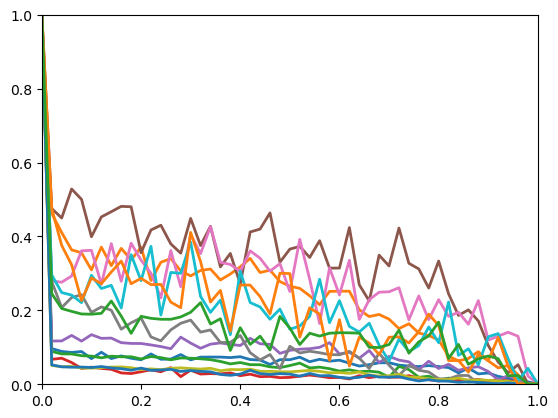

In [23]:
# power for each alpha
for ds in range(13):
    plt.plot(alpha, result_seed_mean[ds,:,1], lw=2, label=f'{ds}')
plt.xlim([0,1])
plt.ylim([0.0,1.0])
# plt.axis('off')
# plt.savefig("../figures/single_acc.pdf", format='pdf', bbox_inches='tight', transparent=True)

## Analysis

In [24]:
results.shape

torch.Size([13, 10, 51, 8])

In [25]:
results_ds_mean = results.mean(0)
results_ds_mean = results_ds_mean[:, :, 6:]
results_ds_mean.shape

torch.Size([10, 51, 2])

In [26]:
summary_mean = results_ds_mean.mean(0)
summary_std  = results_ds_mean.std(0)
print(summary_mean.shape, summary_std.shape)

torch.Size([51, 2]) torch.Size([51, 2])


In [27]:
acc_factor = summary_mean[0,0]
mean_acc = summary_mean[:,0] / acc_factor
std_acc = summary_std[:,0] / acc_factor

power_factor = summary_mean[0,1]
mean_power = summary_mean[:,1] / power_factor
std_power = summary_std[:,1] / power_factor

acc_factor, power_factor

(tensor(0.7140), tensor(7623.6587))

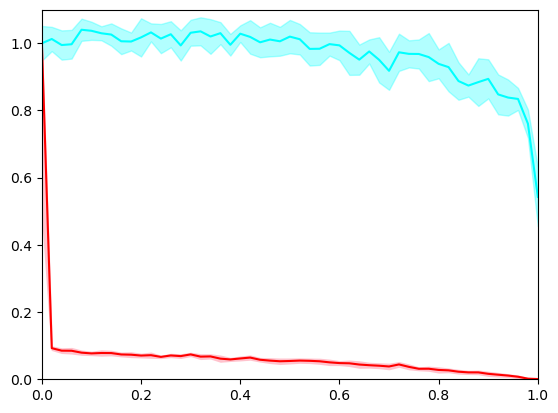

In [28]:
# draw std
plt.fill_between(alpha, mean_acc-std_acc, np.where(mean_acc+std_acc < 1.5, mean_acc+std_acc, 1), alpha=0.3, color='cyan');
plt.fill_between(alpha, mean_power-std_power, np.where(mean_power+std_power < 1, mean_power+std_power, 1), alpha=0.9, color='#FFC0CB');
# draw mean
plt.plot(alpha, mean_acc, color='cyan');
plt.plot(alpha, mean_power, color='red');

plt.xlim([0,1])
plt.ylim([0,1.1])
# plt.axis('off')
plt.savefig("../figures/both.pdf", format='pdf', bbox_inches='tight', transparent=True)

In [29]:
acc_points = results_ds_mean[:,:,0] / acc_factor
power_points = results_ds_mean[:,:,1] / power_factor

In [30]:
acc_points.flatten().max(), power_points.flatten().max()

(tensor(1.1001), tensor(1.8169))

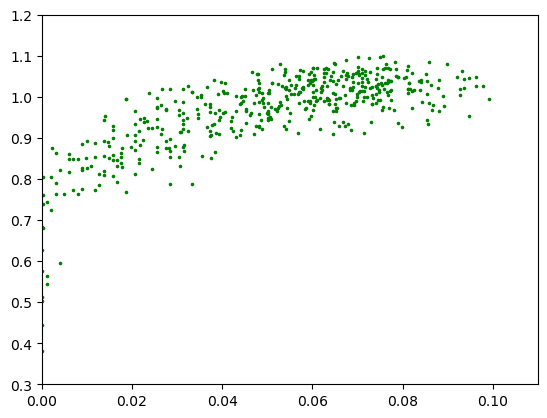

In [31]:
plt.scatter(power_points.flatten(), acc_points.flatten(), color='green', s=2.5)
plt.xlim([0.0,0.11])
plt.ylim([0.3,1.2])
# plt.axis('off')
plt.savefig("../figures/points.pdf", format='pdf', bbox_inches='tight', transparent=True)

In [32]:
acc_points_ft = results[:,:,:,6]
power_points_ft = results[:,:,:,7]
acc_points_ft.shape

torch.Size([13, 10, 51])

In [33]:
lims = [[0,1000 / 1e3],
        [0,1200 / 1e3],
        [0,2000 / 1e3],
        [0,2500 / 1e3],
        [0,1500 / 1e3],
        [0,1500 / 1e3],
        [0,1000 / 1e3],
        [0,1500 / 1e3],
        [0,3000 / 1e3],
        [0,1400 / 1e3],
        [0,1700 / 1e3],
        [0,1400 / 1e3],
        [0,1200 / 1e3]]

In [34]:
power_points_ft[ds].flatten().shape, power_points_ft[0].shape, acc_points_ft[0].mean(0).shape, acc_points_ft[0].mean(0)[0], power_points_ft[0].mean(0)[0]

(torch.Size([510]),
 torch.Size([10, 51]),
 torch.Size([51]),
 tensor(1.),
 tensor(7270.5459))

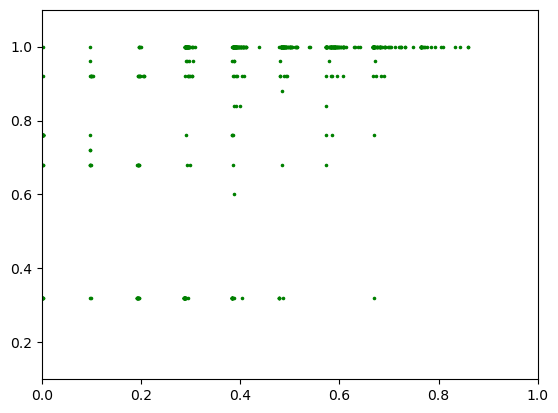

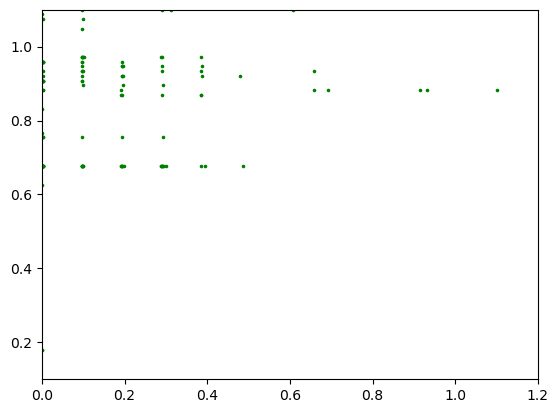

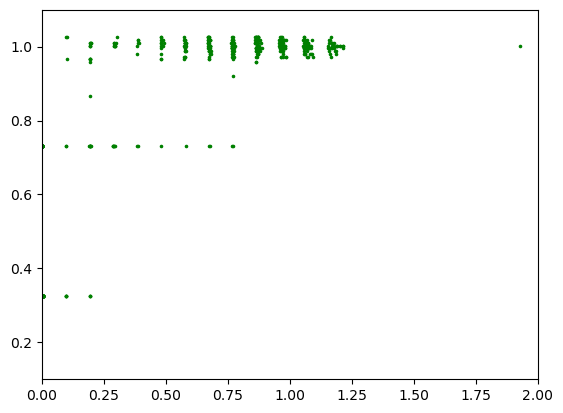

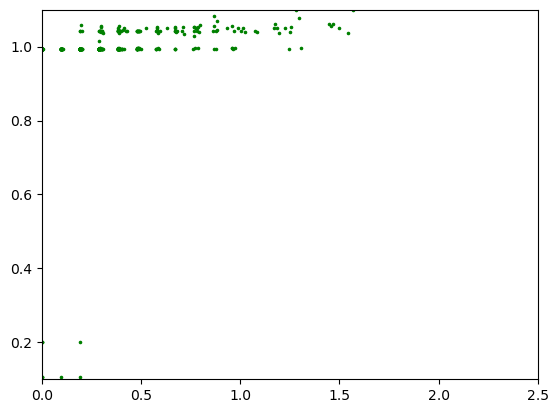

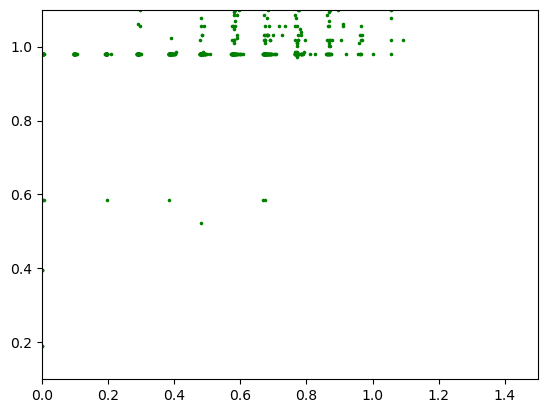

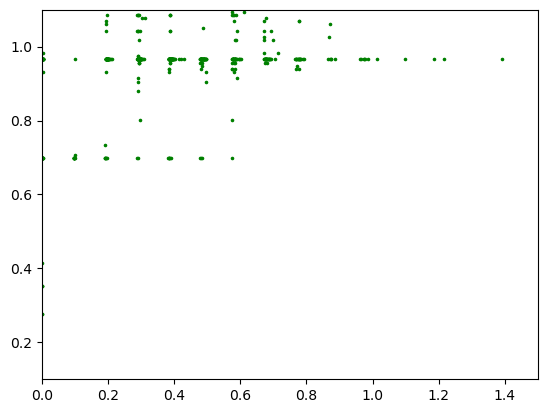

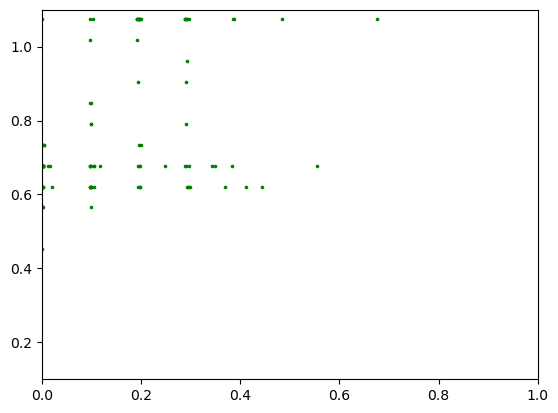

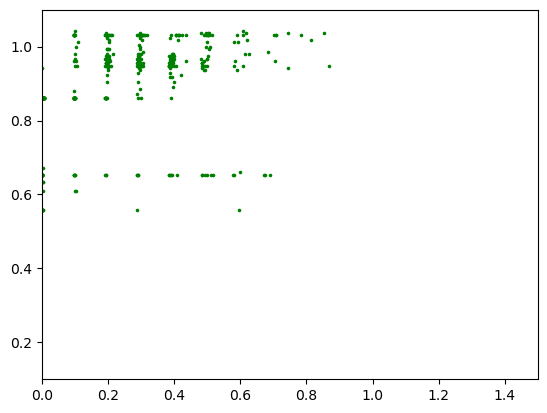

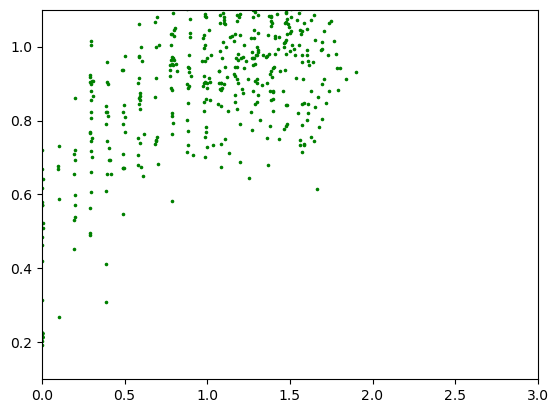

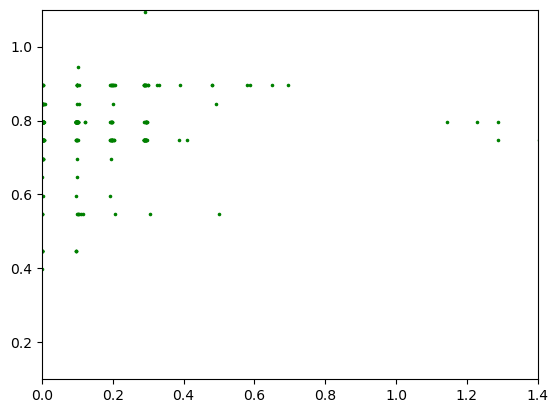

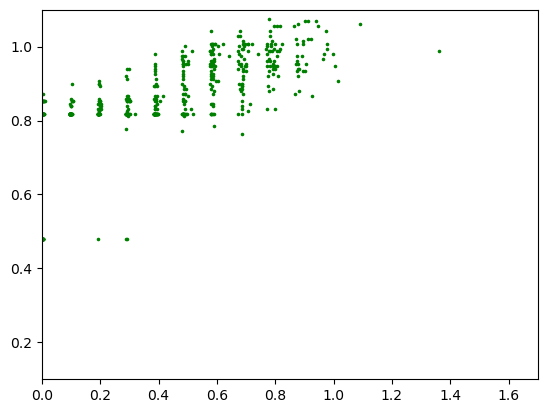

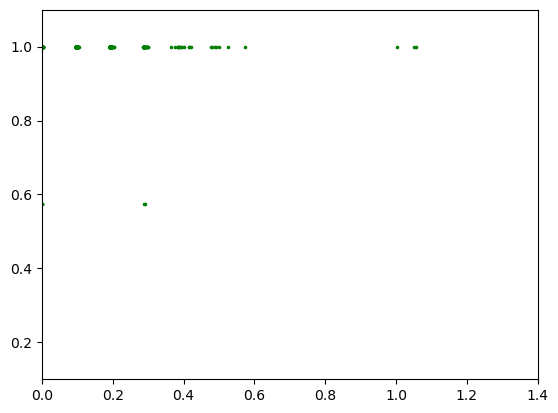

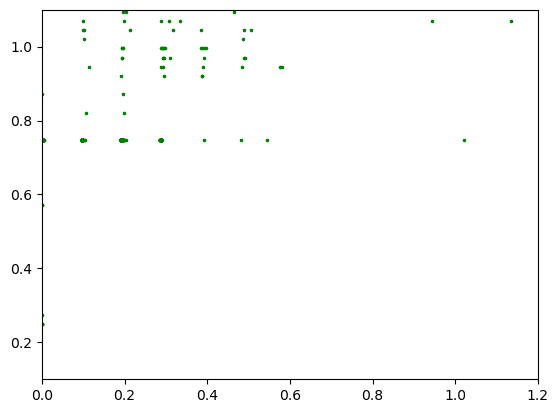

In [35]:
for ds in range (num_dataset):
    plt.figure()
    acc_factor = acc_points_ft[ds].mean(0)[0]
    power_factor = power_points_ft[ds].mean(0)[0]
    plt.scatter(power_points_ft[ds].flatten() * 1e-3, acc_points_ft[ds].flatten()/acc_factor, color='green', s=2.5)
    plt.xlim(lims[ds])
    # plt.xlim([0.0,1.11])
    plt.ylim([0.1,1.1])
    # plt.axis('off')
    plt.savefig("../figures/points.pdf", format='pdf', bbox_inches='tight', transparent=True)

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.spatial import ConvexHull
from scipy.special import comb
from scipy.interpolate import PchipInterpolator, interp1d, CubicSpline, BSpline

# 生成示例数据点（替换为你的实际数据）
points = torch.randn([100, 2]).numpy()

def compute_auxiliary_points(points):
    auxiliary_point_1 = points.min(axis=0) - 1e-4
    auxiliary_point_2 = points.max(axis=0) + 1e-4
    return auxiliary_point_1, auxiliary_point_2

def filter_pareto_front(points):
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    hull_points = hull_points[np.argsort(hull_points[:, 0])]
    pareto_front = [hull_points[0]]
    for point in hull_points[1:]:
        if point[1] > pareto_front[-1][1]:
            pareto_front.append(point)
    return np.array(pareto_front)

def bernstein_poly(i, n, t):
    return comb(n, i) * (t ** i) * ((1 - t) ** (n - i))

def bernstein_poly(i, n, t):
    return comb(n, i) * (t ** i) * ((1 - t) ** (n - i))

def bezier_curve(points, n_times=1000):
    n_points = len(points)
    x_points = np.array([p[0] for p in points])
    y_points = np.array([p[1] for p in points])
    
    t = np.linspace(0.0, 1.0, n_times)
    polynomial_array = np.array([bernstein_poly(i, n_points - 1, t) for i in range(0, n_points)])
    
    xvals = np.dot(x_points, polynomial_array)
    yvals = np.dot(y_points, polynomial_array)
    
    return xvals, yvals

def pchip_curve(points, n_times=1000):
    x = points[:, 0]
    y = points[:, 1]
    pchip = PchipInterpolator(x, y)
    x_smooth = np.linspace(x.min(), x.max(), n_times)
    y_smooth = pchip(x_smooth)
    return x_smooth, y_smooth

def linear_curve(points, n_times=1000):
    x = points[:, 0]
    y = points[:, 1]
    linear_interp = interp1d(x, y, kind='linear')
    x_smooth = np.linspace(x.min(), x.max(), n_times)
    y_smooth = linear_interp(x_smooth)
    return x_smooth, y_smooth

def cubic_spline_curve(points, n_times=1000):
    x = points[:, 0]
    y = points[:, 1]
    cubic_spline = CubicSpline(x, y)
    x_smooth = np.linspace(x.min(), x.max(), n_times)
    y_smooth = cubic_spline(x_smooth)
    return x_smooth, y_smooth

def b_spline_curve(points, n_times=1000):
    x = points[:, 0]
    y = points[:, 1]
    k = 3  # Cubic B-spline
    t = np.linspace(x.min(), x.max(), len(x) - k + 1)
    t = np.concatenate(([x.min()] * k, t, [x.max()] * k))
    b_spline = BSpline(t, y, k)
    x_smooth = np.linspace(x.min(), x.max(), n_times)
    y_smooth = b_spline(x_smooth)
    return x_smooth, y_smooth

def polynomial_fit(points, degree=3, n_times=1000):
    x = points[:, 0]
    y = points[:, 1]
    coefs = np.polyfit(x, y, degree)
    poly = np.poly1d(coefs)
    x_smooth = np.linspace(x.min(), x.max(), n_times)
    y_smooth = poly(x_smooth)
    return x_smooth, y_smooth

def exponential_fit(points, n_times=1000):
    x = points[:, 0]
    y = points[:, 1]
    y = y[y > 0]
    x = x[:len(y)]
    coefs = np.polyfit(x, np.log(y), 1)
    exp_fit = lambda x: np.exp(coefs[1]) * np.exp(coefs[0] * x)
    x_smooth = np.linspace(x.min(), x.max(), n_times)
    y_smooth = exp_fit(x_smooth)
    return x_smooth, y_smooth

def power_fit(points, n_times=1000):
    x = points[:, 0]
    y = points[:, 1]
    valid_indices = (x > 0) & (y > 0)
    x = x[valid_indices]
    y = y[valid_indices]
    coefs = np.polyfit(np.log(x), np.log(y), 1)
    power_fit = lambda x: np.exp(coefs[1]) * x ** coefs[0]
    x_smooth = np.linspace(x.min(), x.max(), n_times)
    y_smooth = power_fit(x_smooth)
    return x_smooth, y_smooth

def logarithmic_fit(points, n_times=1000):
    x = points[:, 0]
    y = points[:, 1]
    valid_indices = x > 0
    x = x[valid_indices]
    y = y[valid_indices]
    coefs = np.polyfit(np.log(x), y, 1)
    log_fit = lambda x: coefs[1] + coefs[0] * np.log(x)
    x_smooth = np.linspace(x.min(), x.max(), n_times)
    y_smooth = log_fit(x_smooth)
    return x_smooth, y_smooth

def clean_data(data, lim):
    clean_data = []
    for i in range(data.shape[0]):
        if data[i,0] <= lim:
            clean_data.append(data[i])
    return np.array(clean_data)
    
def pareto_front(points, limx=None, method='bezier', title='default', delta=0, deltax=0):
    if limx:
        points = clean_data(points, limx[1])
    auxiliary_point_1, auxiliary_point_2 = compute_auxiliary_points(points)
    if limx:
        auxiliary_point_2[0] = limx[1]
    
    pareto = filter_pareto_front(points)
    pareto = np.vstack([pareto, auxiliary_point_2])
    
    if method == 'bezier':
        x_smooth, y_smooth = bezier_curve(pareto)
    elif method == 'pchip':
        x_smooth, y_smooth = pchip_curve(pareto)
    elif method == 'linear':
        x_smooth, y_smooth = linear_curve(pareto)
    elif method == 'cubic_spline':
        x_smooth, y_smooth = cubic_spline_curve(pareto)
    elif method == 'b_spline':
        x_smooth, y_smooth = b_spline_curve(pareto)
    elif method == 'polynomial':
        x_smooth, y_smooth = polynomial_fit(pareto)
    elif method == 'exponential':
        x_smooth, y_smooth = exponential_fit(pareto)
    elif method == 'power':
        x_smooth, y_smooth = power_fit(pareto)
    elif method == 'logarithmic':
        x_smooth, y_smooth = logarithmic_fit(pareto)
    else:
        raise ValueError("Invalid method. Use 'bezier', 'pchip', 'linear', 'cubic_spline', 'b_spline', 'polynomial', 'exponential', 'power', or 'logarithmic'.")

    y_smooth += delta
    x_smooth += deltax
    
    return x_smooth, y_smooth

In [37]:
methods_name = ['bezier', 'pchip', 'linear', 'cubic_spline', 'b_spline', 'polynomial', 'exponential', 'power', 'logarithmic']

In [69]:
methods = ['pchip']*13
methods[1] = 'power'
methods[7] = 'linear'
methods[8] = 'bezier'
methods[9] = 'linear'
methods[10] = 'linear'
methods[6] = 'power'



deltas = [0.] * 13
# deltas[1] = 0.02
# deltas[2] = 0.005
# deltas[4] = 0.005
# deltas[5] = 0.012
# deltas[7] = 0.008
deltas[8] = 0.012

deltaxs = [0.] * 13
deltaxs[2] = -0.08
# deltaxs[8] = 0.5

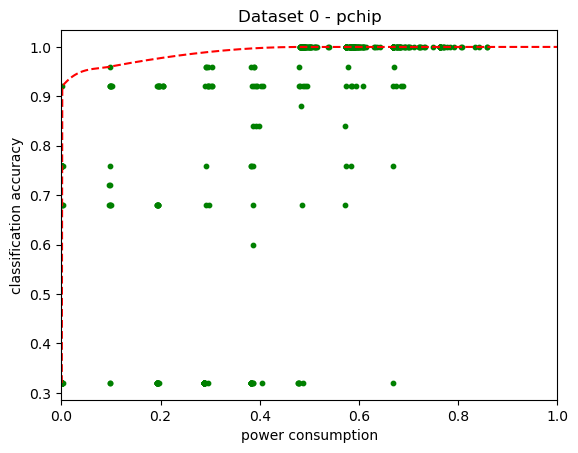

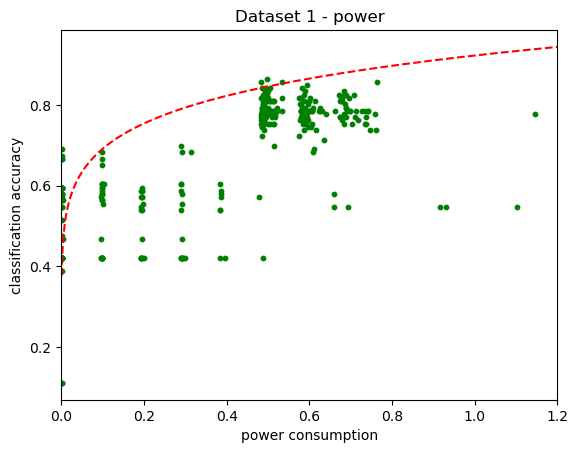

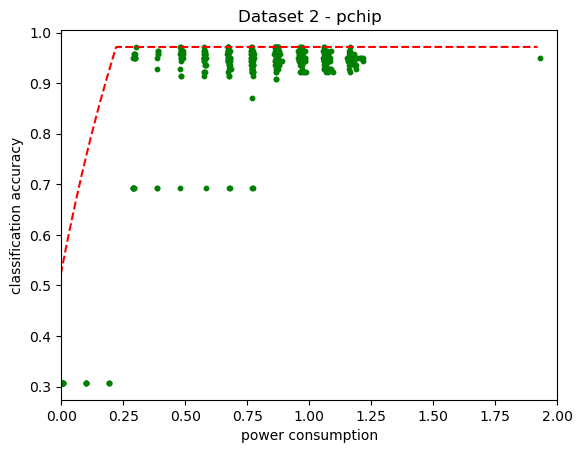

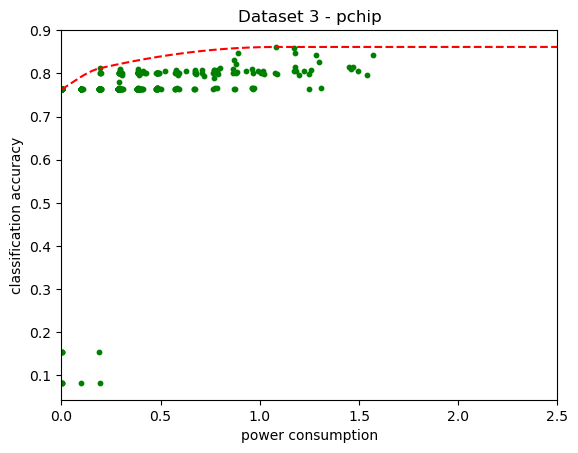

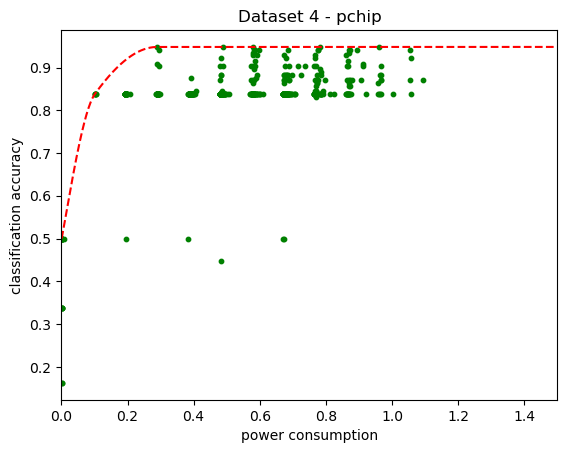

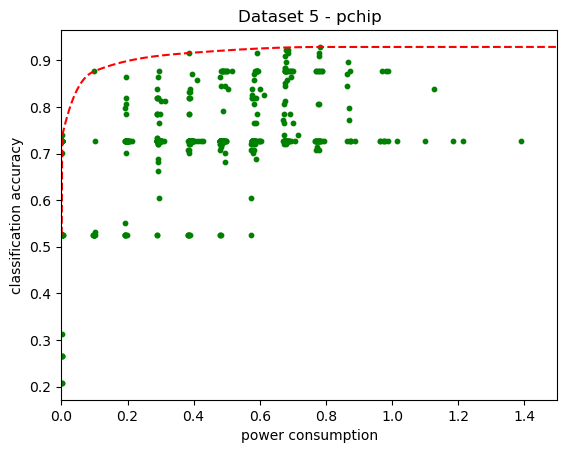

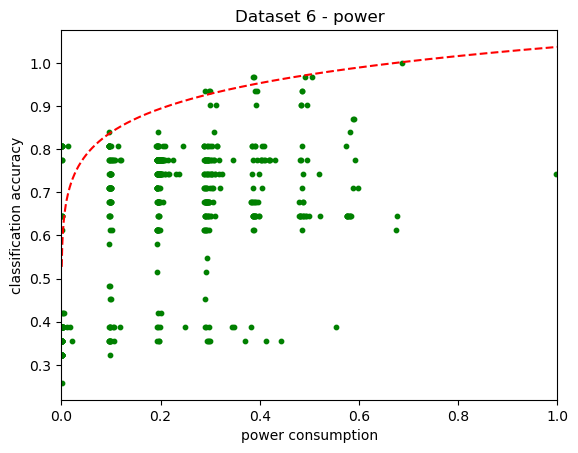

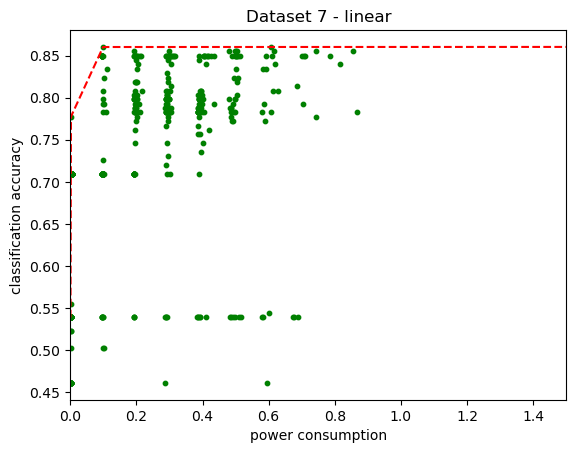

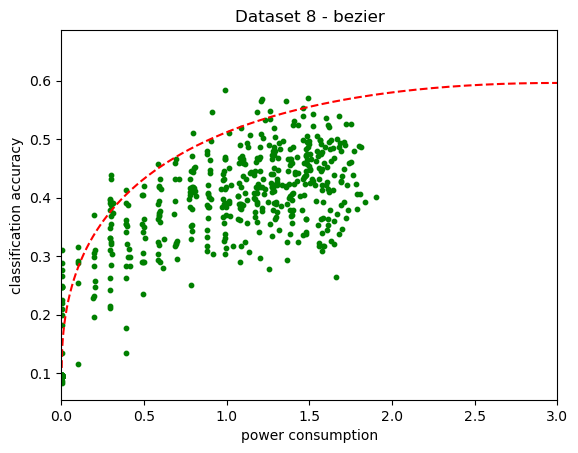

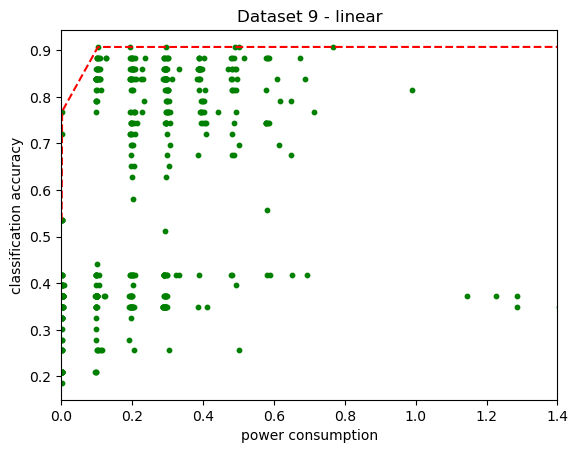

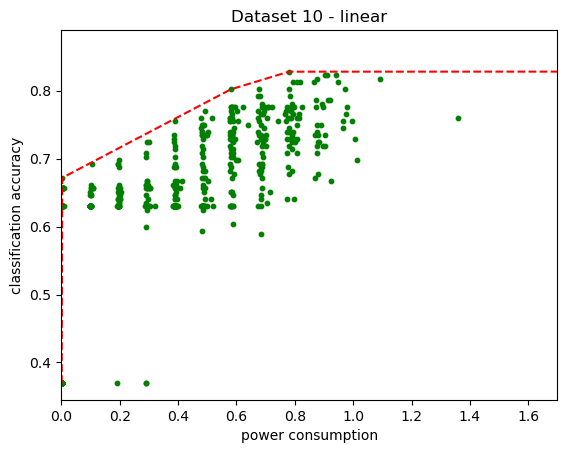

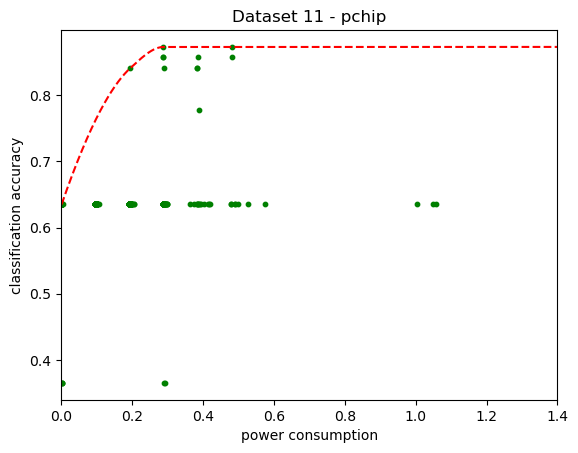

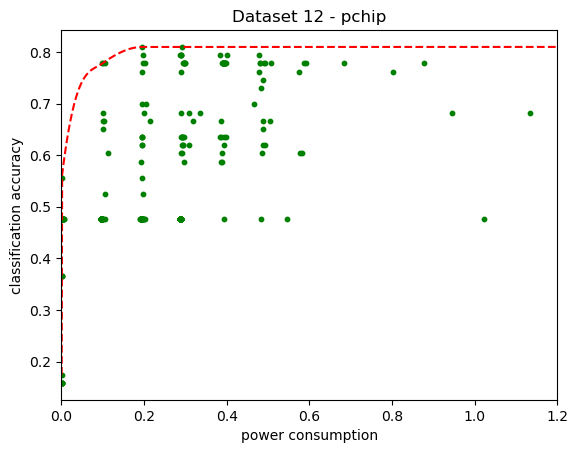

In [70]:
paretos_x = []
paretos_y = []

for ds in range(13):
# for ds in [1]:
    # for m in methods_name:
    #     methods[ds] = m
        
        data = torch.stack([power_points_ft[ds].flatten() * 1e-3, acc_points_ft[ds].flatten()], dim=1).numpy()
        if ds == 0:
            x = data[:,0]
            y = data[:,1]
            invalid = (x<0.48) & (y>0.98)
            valid = ~invalid
            data = data[valid]
        if ds == 1:
            x = data[:,0]
            y = data[:,1]
            invalid = (x<0.48) & (y>0.7)
            valid = ~invalid
            data = data[valid]
        if ds == 2:
            x = data[:,0]
            y = data[:,1]
            invalid = (x<0.2) & (y>0.6)
            valid = ~invalid
            data = data[valid]
        if ds == 4:
            x = data[:,0]
            y = data[:,1]
            invalid = (x<0.1) & (y>0.8)
            valid = ~invalid
            data = data[valid]
        if ds == 6:
            x = data[:,0]
            y = data[:,1]
            invalid = (x<0.25) & (y>0.9)
            valid = ~invalid
            data = data[valid]
        if ds == 8:
            x = data[:,0]
            y = data[:,1]
            invalid = (x<0.2) & (y>0.85)
            valid = ~invalid
            data = data[valid]
        if ds == 10:
            x = data[:,0]
            y = data[:,1]
            invalid = (x<0.8) & (y>0.9)
            valid = ~invalid
            data = data[valid]
            
        pareto_x, pareto_y = pareto_front(data, lims[ds], methods[ds], ds, delta=deltas[ds], deltax=deltaxs[ds])
        
        paretos_x.append(pareto_x)
        paretos_y.append(pareto_y)

        plt.figure()
        plt.scatter(data[:, 0], data[:, 1], color='green', s=10)
        plt.plot(pareto_x, pareto_y, '--', color='r')
        plt.xlabel('power consumption')
        plt.ylabel('classification accuracy')
        plt.xlim(lims[ds])
        
        plt.title(f'Dataset {ds} - {methods[ds]}')
        
        # plt.axis('off')
        # plt.savefig(f"../figures/{ds}.pdf", format='pdf', bbox_inches='tight', transparent=True)
        plt.show()

In [71]:
paretos_x = np.array(paretos_x)
paretos_y = np.array(paretos_y)
pareto = np.stack([paretos_x,paretos_y])
pareto = torch.tensor(pareto).permute(1,0,2)
torch.save(pareto, '../RESULT/pareto_baseline_hs.curves')

In [72]:
pareto.shape

torch.Size([13, 2, 1000])

In [41]:
pareto

tensor([[[ 8.1413e-04,  1.8143e-03,  2.8145e-03,  ...,  9.9800e-01,
           9.9900e-01,  1.0000e+00],
         [ 3.2000e-01,  9.2060e-01,  9.2182e-01,  ...,  1.0001e+00,
           1.0001e+00,  1.0001e+00]],

        [[ 7.7695e-04,  7.7702e-04,  7.7709e-04,  ...,  1.1916e+00,
           1.1958e+00,  1.2000e+00],
         [ 1.1111e-01,  1.1325e-01,  1.1539e-01,  ...,  8.6517e-01,
           8.6518e-01,  8.6518e-01]],

        [[-7.9356e-02, -7.7355e-02, -7.5354e-02,  ...,  1.9160e+00,
           1.9180e+00,  1.9200e+00],
         [ 6.9286e-01,  6.9499e-01,  6.9715e-01,  ...,  9.7153e-01,
           9.7153e-01,  9.7153e-01]],

        ...,

        [[ 9.8241e-04,  2.6831e-03,  4.3838e-03,  ...,  1.6966e+00,
           1.6983e+00,  1.7000e+00],
         [ 3.6979e-01,  6.6445e-01,  6.7218e-01,  ...,  8.2822e-01,
           8.2822e-01,  8.2823e-01]],

        [[ 5.4250e-04,  1.9434e-03,  3.3442e-03,  ...,  1.3972e+00,
           1.3986e+00,  1.4000e+00],
         [ 6.3492e-01,  6.3709e-0

## Other code

In [215]:
ds = 6
data = torch.stack([power_points_ft[ds].flatten() * 1e-3, acc_points_ft[ds].flatten()], dim=1).numpy()
if ds == 0:
    x = data[:,0]
    y = data[:,1]
    invalid = (x<0.48) & (y>0.98)
    valid = ~invalid
    data = data[valid]
if ds == 2:
    x = data[:,0]
    y = data[:,1]
    invalid = (x<0.7) & (y>0.95)
    valid = ~invalid
    data = data[valid]
    
data = clean_data(data, lims[ds][1])


In [211]:
x = np.array(data[:,0])
y = np.array(data[:,1])
x.shape, y.shape

((371,), (371,))

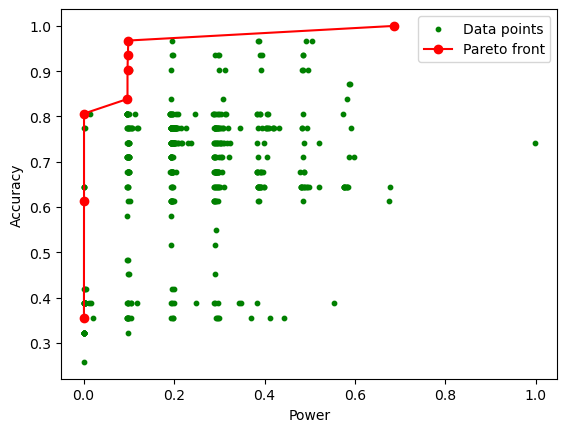

In [216]:
import numpy as np
import matplotlib.pyplot as plt

# # Replace these with your actual data
# x = np.random.rand(100) * 2  # Example power values
# y = np.random.rand(100) * 0.8 + 0.3  # Example accuracy values
ds = 6
data = torch.stack([power_points_ft[ds].flatten() * 1e-3, acc_points_ft[ds].flatten()], dim=1).numpy()
if ds == 0:
    x = data[:,0]
    y = data[:,1]
    invalid = (x<0.48) & (y>0.98)
    valid = ~invalid
    data = data[valid]
if ds == 2:
    x = data[:,0]
    y = data[:,1]
    invalid = (x<0.7) & (y>0.95)
    valid = ~invalid
    data = data[valid]
    
data = clean_data(data, lims[ds][1])

x = np.array(data[:,0])
y = np.array(data[:,1])


# Combine x and y into points and sort by x (power)
points = np.array(list(zip(x, y)))
points = points[points[:, 0].argsort()]

# Initialize Pareto front
pareto_front = [points[0]]
max_accuracy = points[0][1]  # Start with the accuracy of the first point

# Find Pareto front
for point in points[1:]:
    if point[1] > max_accuracy:
        pareto_front.append(point)
        max_accuracy = point[1]

pareto_front = np.array(pareto_front)

# Plot the scatter plot and Pareto front
plt.scatter(x, y, color="green", s=10, label="Data points")
plt.plot(pareto_front[:, 0], pareto_front[:, 1], color="red", marker="o", label="Pareto front")
plt.xlabel("Power")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


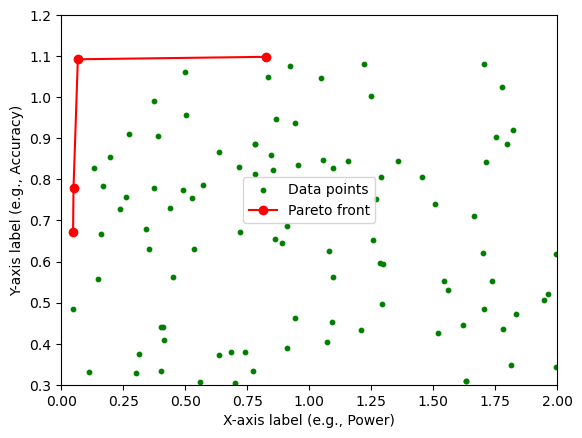

In [154]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data for x (e.g., power) and y (e.g., accuracy) based on your plot
# Replace `x` and `y` with your actual data
x = np.random.rand(100) * 2  # Example x values
y = np.random.rand(100) * 0.8 + 0.3  # Example y values scaled similarly to the plot

# Sort points by x value
points = np.array(list(zip(x, y)))
points = points[points[:, 0].argsort()]

# Find the Pareto front
pareto_front = [points[0]]
for point in points[1:]:
    if point[1] > pareto_front[-1][1]:  # Keep points that have a higher y value
        pareto_front.append(point)

pareto_front = np.array(pareto_front)

# Plot the points
plt.scatter(x, y, color="green", s=10, label="Data points")
plt.plot(pareto_front[:, 0], pareto_front[:, 1], color="red", marker="o", label="Pareto front")
plt.xlim([0, 2])
plt.ylim([0.3, 1.2])
plt.xlabel("X-axis label (e.g., Power)")
plt.ylabel("Y-axis label (e.g., Accuracy)")
plt.legend()
plt.show()


In [9]:
power = results[:,:,:,5]
power.shape

torch.Size([13, 10, 51])

In [10]:
import matplotlib.pyplot as  plt

In [11]:
gammas = torch.linspace(0,1,51)

In [13]:
power[0,:,0] / 1e6

tensor([0.0015, 0.0026, 0.0012, 0.0279, 0.0054, 0.0188, 0.0016, 0.0082, 0.0021,
        0.0039])

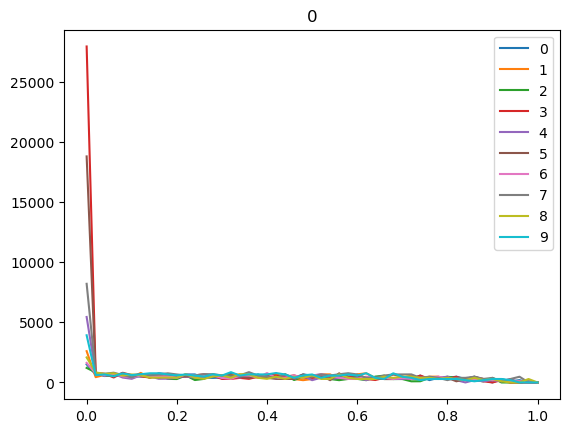

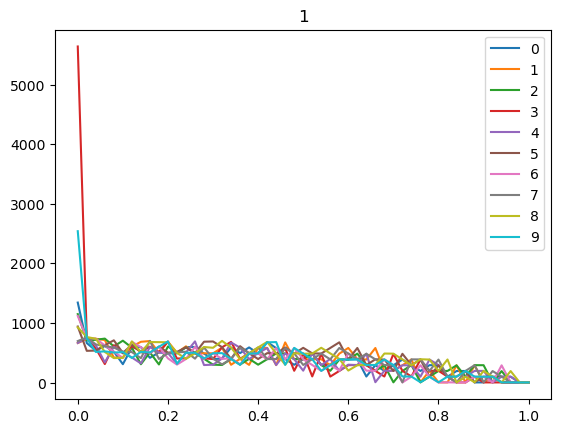

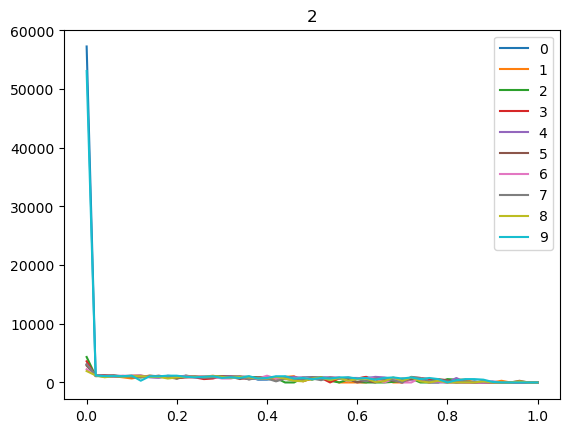

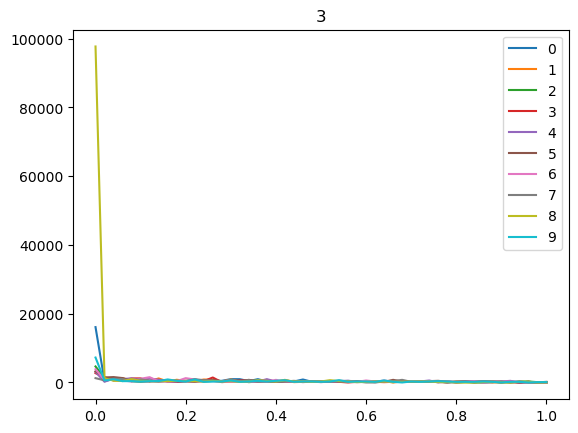

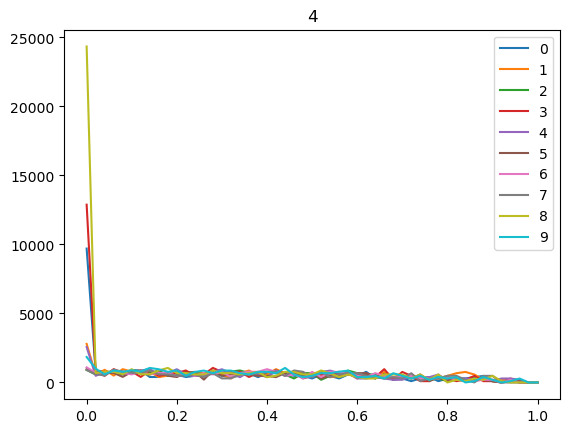

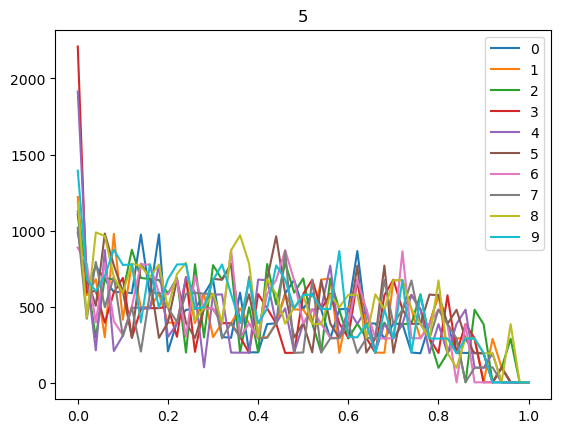

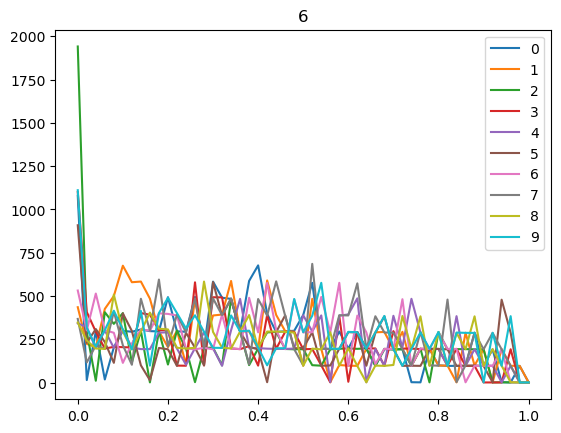

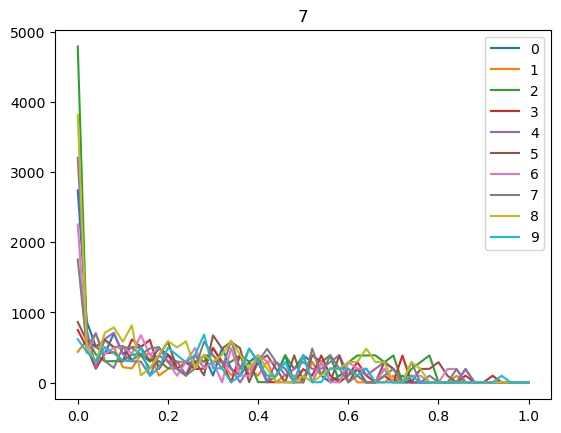

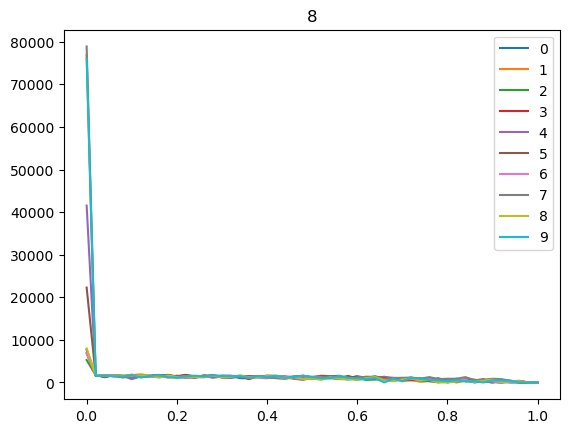

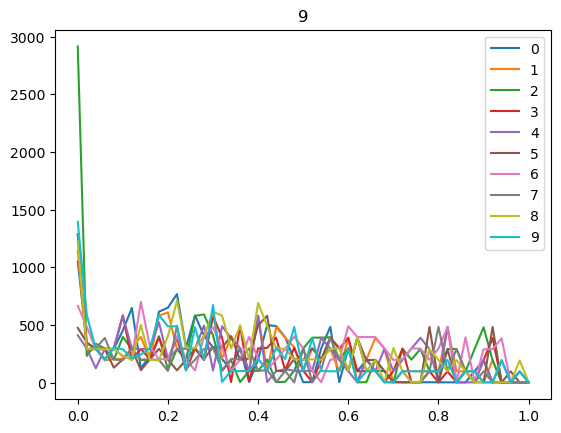

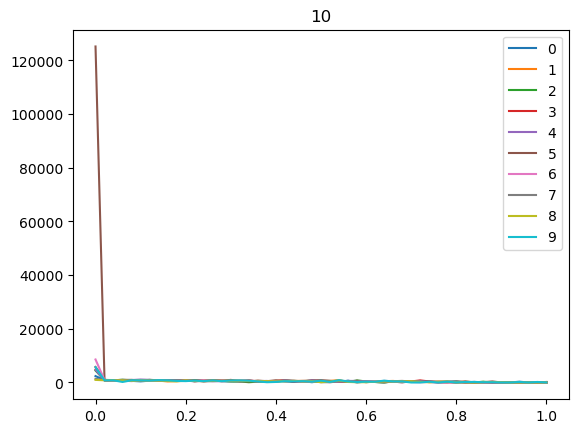

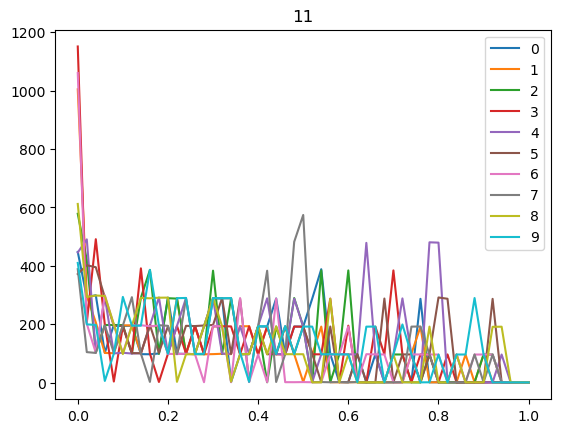

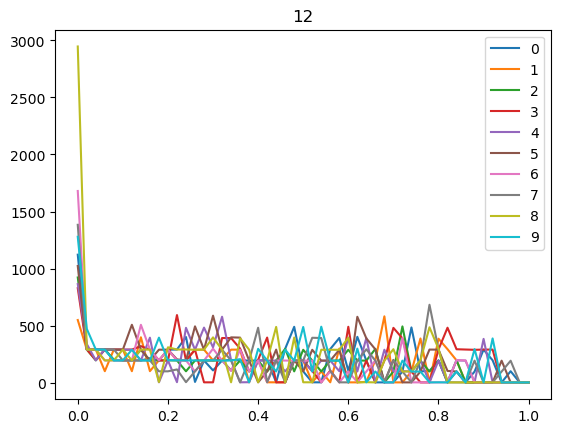

In [12]:
for i in range(num_dataset):
    plt.figure()
    for seed in range(num_seeds):
        plt.plot(gammas, power[i,seed,:], label=f'{seed}')
        plt.title(f'{i}')
        plt.legend()

In [13]:
min_power = [0.] * 13
max_power = [1000., 1200., 2000., 2500., 1500., 1500., 1000., 1500., 3000., 1400., 1700., 1400., 1200.]

In [14]:
power = torch.stack([torch.tensor(min_power), torch.tensor(max_power)])

In [15]:
power.shape

torch.Size([2, 13])

In [16]:
delta = (power[1] - power[0]) / 5
delta

tensor([200., 240., 400., 500., 300., 300., 200., 300., 600., 280., 340., 280.,
        240.])

In [17]:
target = torch.stack([delta * i for i in range(1,5)])
target

tensor([[ 200.,  240.,  400.,  500.,  300.,  300.,  200.,  300.,  600.,  280.,
          340.,  280.,  240.],
        [ 400.,  480.,  800., 1000.,  600.,  600.,  400.,  600., 1200.,  560.,
          680.,  560.,  480.],
        [ 600.,  720., 1200., 1500.,  900.,  900.,  600.,  900., 1800.,  840.,
         1020.,  840.,  720.],
        [ 800.,  960., 1600., 2000., 1200., 1200.,  800., 1200., 2400., 1120.,
         1360., 1120.,  960.]])

In [18]:
target.shape

torch.Size([4, 13])